In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# -----------------------------
# 1. Load all GTFS-related files
# -----------------------------


# Explicit variables for convenience when working in notebooks or scripts.
calendar_dates = pd.read_csv("data/calendar_dates.txt")
calendar = pd.read_csv("data/calendar.txt")

direction_names_exceptions = pd.read_csv("data/direction_names_exceptions.txt")
directions = pd.read_csv("data/directions.txt")

route_names_exceptions = pd.read_csv("data/route_names_exceptions.txt")
routes = pd.read_csv("data/routes.txt")

shapes = pd.read_csv("data/shapes.txt")
signup_periods = pd.read_csv("data/signup_periods.txt")

stop_order_exceptions = pd.read_csv("data/stop_order_exceptions.txt")
stop_times = pd.read_csv("data/stop_times.txt")
stops = pd.read_csv("data/stops.txt")
transfers = pd.read_csv("data/transfers.txt")
trips = pd.read_csv("data/trips.txt")


In [2]:
# 2. Null Check

dfs = [calendar_dates, calendar, 
       direction_names_exceptions, 
       directions, 
       route_names_exceptions, routes, shapes, signup_periods, 
       stop_order_exceptions, stop_times, stops, transfers, trips] 

for i, df in enumerate(dfs, start=1):
    print(f"\nDataFrame {i}")
    print(df.isnull().sum())


DataFrame 1
service_id        0
date              0
exception_type    0
dtype: int64

DataFrame 2
service_id    0
monday        0
tuesday       0
wednesday     0
thursday      0
friday        0
saturday      0
sunday        0
start_date    0
end_date      0
dtype: int64

DataFrame 3
route_name        0
direction_id      0
direction_name    0
direction_do      0
dtype: int64

DataFrame 4
direction           0
direction_id        0
route_id            0
route_short_name    0
LineIdConst         0
dtype: int64

DataFrame 5
route_id       0
route_name     0
route_do      33
name_type      0
dtype: int64

DataFrame 6
route_id              0
agency_id             0
route_short_name      4
route_long_name       0
route_desc          242
route_type            0
route_url           242
route_color         230
route_text_color    230
dtype: int64

DataFrame 7
shape_id               0
shape_pt_lat           0
shape_pt_lon           0
shape_pt_sequence      0
shape_dist_traveled    0
dtype: int64

In [3]:
for i, df in enumerate(dfs, start=1):
    print(f"\nDataFrame {i}")
    print(df.shape[0])


DataFrame 1
732

DataFrame 2
27

DataFrame 3
493

DataFrame 4
502

DataFrame 5
33

DataFrame 6
242

DataFrame 7
220017

DataFrame 8
2

DataFrame 9
82

DataFrame 10
1833708

DataFrame 11
8817

DataFrame 12
10423

DataFrame 13
62537


In [4]:
# Join onto trips (trips is the “big” table, so start from it)
calendar_trips = (
    trips
    .merge(calendar, on="service_id", how="left", validate="many_to_one")
)

calendar_trips.head()

,route_id,service_id,trip_id,trip_headsign,trip_short_name,direction_id,block_id,shape_id,wheelchair_accessible,bikes_allowed,monday,tuesday,wednesday,thursday,friday,saturday,sunday,start_date,end_date
0,6612,1,14827490,2 Macdonald/To Burrard Station,NaN,0,2159340.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
1,6612,1,14827491,2 Macdonald/To Burrard Station,NaN,0,2159341.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
2,6612,1,14827492,2 Macdonald/To Burrard Station,NaN,0,2159339.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
3,6612,1,14827493,2 Macdonald/To Burrard Station,NaN,0,2159335.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419
4,6612,1,14827494,2 Macdonald/To Burrard Station,NaN,0,2159340.0,309728,0,1,1,1,1,1,1,0,0,20260105,20260419


In [5]:
# Split HH:MM:SS into columns
hms = stop_times["arrival_time"].str.split(":", expand=True).astype(int)

# Convert to total seconds
stop_times["arrival_sec"] = (
    hms[0] * 3600 +
    hms[1] * 60 +
    hms[2]
)

hms_dep = stop_times["departure_time"].str.split(":", expand=True).astype(int)

stop_times["departure_sec"] = (
    hms_dep[0] * 3600 +
    hms_dep[1] * 60 +
    hms_dep[2]
)

trip_duration = (
    stop_times
    .groupby("trip_id", as_index=False)
    .agg(
        start_time=("departure_sec", "min"),
        end_time=("arrival_sec", "max")
    )
)

trip_duration["trip_duration_min"] = (
    (trip_duration["end_time"] - trip_duration["start_time"]) / 60
)

trips_final = trips.merge(
    trip_duration[["trip_id", "trip_duration_min"]],
    on="trip_id",
    how="left",
    validate="one_to_one"
)

trips_info_for_analysis = trips_final[["route_id", "trip_id", "trip_headsign", "trip_duration_min"]]
trips_info_for_analysis

,route_id,trip_id,trip_headsign,trip_duration_min
0,6612,14827490,2 Macdonald/To Burrard Station,25.0
1,6612,14827491,2 Macdonald/To Burrard Station,27.0
2,6612,14827492,2 Macdonald/To Burrard Station,30.0
3,6612,14827493,2 Macdonald/To Burrard Station,30.0
4,6612,14827494,2 Macdonald/To Burrard Station,30.0
...,...,...,...,...
62532,6692,15073635,255 Park Royal Only,29.0
62533,6692,15073636,255 Park Royal Only,30.0
62534,6692,15073637,255 Park Royal Only,38.0
62535,6692,15073638,255 Park Royal Only,38.0


In [6]:
print(trips["trip_headsign"].unique().shape[0])
print((trips_final["trip_duration_min"] < 0).sum())

619
0


In [7]:
avg_duration_by_headsign = (
    trips_info_for_analysis
    .groupby("trip_headsign", as_index=False)
    .agg(
        avg_trip_duration_min=("trip_duration_min", "mean"),
        trip_count=("trip_id", "count")   # optional but useful
    )
)

avg_duration_by_headsign.head()

,trip_headsign,avg_trip_duration_min,trip_count
0,321 King George Blvd/To Scott Rd Station,77.360000,25
1,10 Granville/To Davie St,27.800000,5
2,10 Granville/To Marine Dr Station,44.705882,238
3,10 Granville/To Marpole Loop,34.000000,8
4,10 Granville/To Waterfront Station,45.540000,250


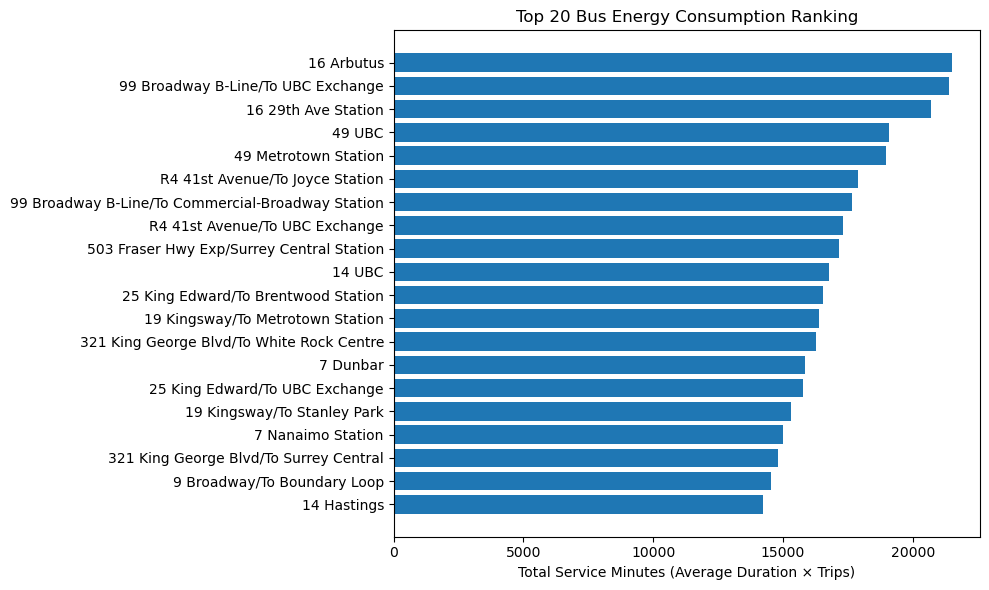

In [8]:
# 1️⃣ Keep only headsigns starting with a number
exclude_headsigns = [
    # Canada Line
    "Canada Line To Waterfront",
    "Canada Line To YVR-Airport",
    "Canada Line To Richmond-Brighouse",
    "Canada Line To Bridgeport",

    # SeaBus
    "SeaBus Northbound To Lonsdale Quay",
    "SeaBus Southbound To Waterfront",

    # West Coast Express
    "West Coast Express Train To Waterfront",

    # Millennium Line
    "Millennium Line To Lafarge Lake-Douglas",
    "Millennium Line To Lougheed Town Centre",
    "Millennium Line To VCC-Clark",

    # Expo Line
    "Expo Line To Braid",
    "Expo Line To King George",
    "Expo Line To Production Way-University",
    "Expo Line To Lougheed Town Centre",
    "Expo Line To Waterfront",
    "Expo Line To New Westminster",
]

bus_df = avg_duration_by_headsign[
    ~avg_duration_by_headsign["trip_headsign"].isin(exclude_headsigns)
].copy()

# 2️⃣ Compute service minutes
bus_df["service_minutes"] = (
    bus_df["avg_trip_duration_min"] *
    bus_df["trip_count"]
)

# 3️⃣ Take Top 20 AFTER filtering
plot_20_df = bus_df.nlargest(20, "service_minutes") \
                .sort_values("service_minutes")

# 4️⃣ Plot
plt.figure(figsize=(10, 6))
plt.barh(plot_20_df["trip_headsign"], plot_20_df["service_minutes"])
plt.xlabel("Total Service Minutes (Average Duration × Trips)")
plt.title("Top 20 Bus Energy Consumption Ranking")
plt.tight_layout()
plt.show()

In [9]:
# bus_df all buses calculated service_minutes
# plot_20_df top 20 buses


In [10]:
bus_df

,trip_headsign,avg_trip_duration_min,trip_count,service_minutes
0,321 King George Blvd/To Scott Rd Station,77.360000,25,1934.000000
1,10 Granville/To Davie St,27.800000,5,139.000000
2,10 Granville/To Marine Dr Station,44.705882,238,10640.000000
3,10 Granville/To Marpole Loop,34.000000,8,272.000000
4,10 Granville/To Waterfront Station,45.540000,250,11385.000000
...,...,...,...,...
610,R6 Scott Road/To Newton Exchange,31.580547,329,10390.000000
611,R6 Scott Road/To Scott Rd Station,31.080357,336,10443.000000
612,School Special,19.500000,4,78.000000
615,Special,23.692157,17,402.766667


In [11]:
trip_duration

,trip_id,start_time,end_time,trip_duration_min
0,14827490,18600,20100,25.0
1,14827491,19680,21300,27.0
2,14827492,20700,22500,30.0
3,14827493,21900,23700,30.0
4,14827494,22740,24540,30.0
...,...,...,...,...
62531,15073634,81660,83400,29.0
62532,15073635,83880,85620,29.0
62533,15073636,85620,87420,30.0
62534,15073637,87900,90180,38.0


In [12]:
rail_trip_ids = trips[
    trips["trip_headsign"].isin(exclude_headsigns)
]["trip_id"].unique()

rail_trip_ids[:10]  # preview

# Choose interval size (minutes)
INTERVAL_MIN = 30
interval_sec = INTERVAL_MIN * 60

# Bin trips by START time (most common)
trip_duration["start_bin_sec"] = (trip_duration["start_time"] // interval_sec) * interval_sec

# Pretty label (note: GTFS can exceed 24:00:00)
trip_duration["start_bin_label"] = (
    (trip_duration["start_bin_sec"] // 3600).astype(int).astype(str).str.zfill(2)
    + ":" +
    ((trip_duration["start_bin_sec"] % 3600) // 60).astype(int).astype(str).str.zfill(2)
)

trip_duration = trip_duration[
    ~trip_duration["trip_id"].isin(rail_trip_ids)
].copy()
# All data were rounded to its closest time interval
trip_duration.head()

,trip_id,start_time,end_time,trip_duration_min,start_bin_sec,start_bin_label
0,14827490,18600,20100,25.0,18000,05:00
1,14827491,19680,21300,27.0,18000,05:00
2,14827492,20700,22500,30.0,19800,05:30
3,14827493,21900,23700,30.0,21600,06:00
4,14827494,22740,24540,30.0,21600,06:00


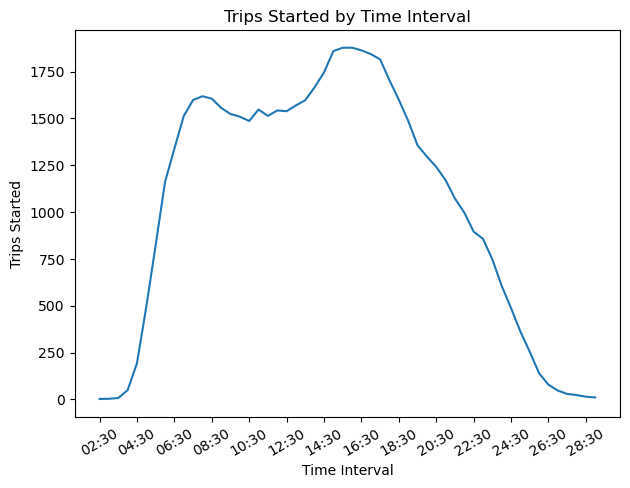

In [13]:
trips_by_interval = (
    trip_duration
    .groupby(["start_bin_label"], as_index=False)
    .size()
    .rename(columns={"size": "trips_started"})
    .sort_values("start_bin_label")
)

# Ensure sorted correctly
trips_by_interval = trips_by_interval.sort_values("start_bin_label")

plt.figure()
plt.plot(trips_by_interval["start_bin_label"],
         trips_by_interval["trips_started"])

plt.xlabel("Time Interval")
plt.ylabel("Trips Started")
plt.title("Trips Started by Time Interval")

plt.tight_layout()
plt.xticks(
    trips_by_interval["start_bin_label"][::4],
    rotation=30
)
plt.show()

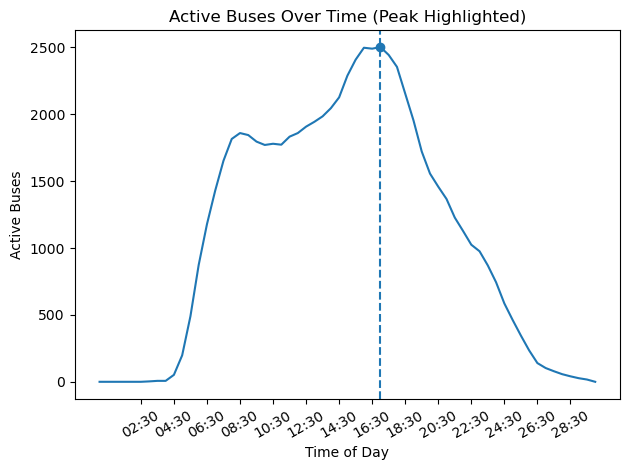

In [14]:
max_end = trip_duration["end_time"].max()
times = np.arange(0, max_end + interval_sec, interval_sec)

start = trip_duration["start_time"].to_numpy()
end = trip_duration["end_time"].to_numpy()

active = []

for t in times:
    active.append(((start <= t) & (end > t)).sum())

active_by_interval = pd.DataFrame({
    "interval_start_sec": times,
    "active_trips": active
})

active_by_interval["label"] = (
    (active_by_interval["interval_start_sec"] // 3600)
    .astype(int)
    .astype(str)
    .str.zfill(2)
    + ":" +
    ((active_by_interval["interval_start_sec"] % 3600) // 60)
    .astype(int)
    .astype(str)
    .str.zfill(2)
)

# Find peak
peak_idx = active_by_interval["active_trips"].idxmax()
peak_row = active_by_interval.loc[peak_idx]
peak_time = peak_row["label"]
peak_value = peak_row["active_trips"]

plt.figure()

# Plot full curve
plt.plot(active_by_interval["label"],
         active_by_interval["active_trips"])

# Highlight peak point
plt.scatter(peak_time, peak_value)

# Add vertical dashed line at peak index position
plt.axvline(x=peak_idx, linestyle="--")

plt.title("Active Buses Over Time (Peak Highlighted)")
plt.xlabel("Time of Day")
plt.ylabel("Active Buses")

plt.xticks(
    trips_by_interval["start_bin_label"][::4],
    rotation=30
)
plt.tight_layout()
plt.show()

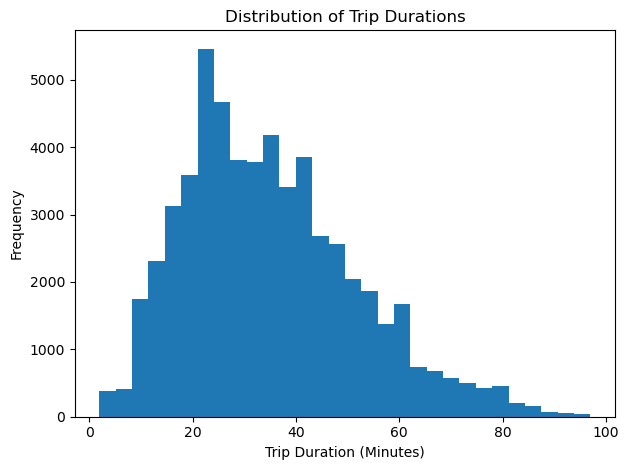

In [15]:
plt.figure()
plt.hist(trip_duration["trip_duration_min"], bins=30)
plt.xlabel("Trip Duration (Minutes)")
plt.ylabel("Frequency")
plt.title("Distribution of Trip Durations")
plt.tight_layout()
plt.show()

In [21]:
trip_duration_route_id_included = trip_duration.merge(
    trips[["trip_id", "route_id"]],
    on="trip_id",
    how="left",
    validate="one_to_one"
)

trip_duration_with_route_name = trip_duration_route_id_included.merge(
    routes[["route_id", "route_long_name"]],
    on="route_id",
    how="left",
    validate="many_to_one"
)

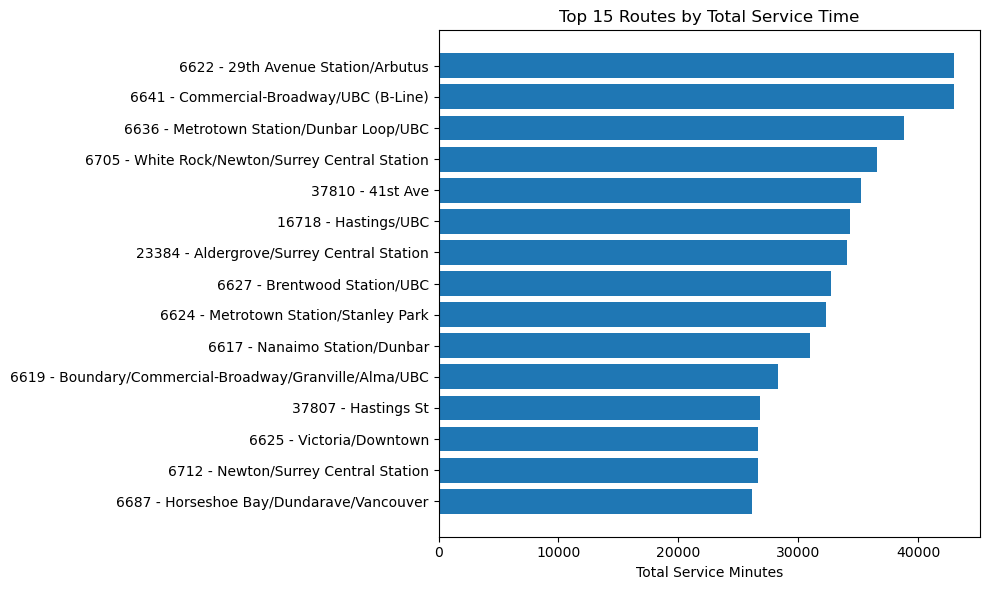

In [22]:
route_service = (
    trip_duration_with_route_name
    .groupby(["route_id", "route_long_name"], as_index=False)
    ["trip_duration_min"]
    .sum()
    .sort_values("trip_duration_min", ascending=False)
)

plt.figure(figsize=(10, 6))

top15 = route_service.head(15)

plt.barh(
    top15["route_id"] + " - " + top15["route_long_name"],
    top15["trip_duration_min"]
)

plt.xlabel("Total Service Minutes")
plt.title("Top 15 Routes by Total Service Time")

plt.gca().invert_yaxis()  # highest on top
plt.tight_layout()
plt.show()